<a href="https://colab.research.google.com/github/Ashwanikumarkashyap/modifiedMobileNetV1-CNN/blob/master/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as     tf
from   tensorflow import keras

In [0]:
tf.__version__

'2.2.0-rc2'

In [0]:
# tensorflow datasets
import tensorflow_datasets as tfds

In [0]:
# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt

In [0]:
# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

In [0]:
# model
MODEL_LEVEL_0_BLOCKS    = 4
MODEL_LEVEL_1_BLOCKS    = 6
MODEL_LEVEL_2_BLOCKS    = 3

In [0]:
# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_BN_MOMENTUM     = 0.99
TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 55
DEPTH_MULTIPLIER = 1
RESOLUTION_MULTIPLIER = 1

In [0]:
# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

In [0]:
# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

In [0]:
# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [0]:
# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

In [0]:
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)
dataset_train_np = tfds.as_numpy(dataset_train)
dataset_test_np = tfds.as_numpy(dataset_test)


In [0]:
# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

In [0]:
# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)

In [0]:
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Dropout, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Add
from tensorflow.keras.models import Model
from keras import regularizers

# define the calculation of each 'inverted Res_Block'
def mobileNet_block(x, filters, stride, depth_multiplier, block_id):
    prefix = 'block_{}_'.format(block_id)

    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, depth_multiplier = depth_multiplier, activation=None, use_bias=False, padding='same', kernel_initializer="he_normal", depthwise_regularizer=regularizers.l2(4e-5), name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'depthwise_BN')(x)
    x = ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Pointwise
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False, activation=None, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    x = ReLU(6., name=prefix + 'pointwise_relu')(x)

    return x

#Create Build
def create_model(rows, cols, channels, level_0_blocks, level_1_blocks, level_2_blocks, num_classes, lr_initial):
    
    # encoder - input
    model_input = keras.Input(shape=(rows, cols, channels), name='input_image')
    x = model_input

    # model architechture
    x = Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(4e-5), name='Conv1')(model_input)

    x = mobileNet_block(x, filters=64, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=0)
    x = mobileNet_block(x, filters=64, stride=2, depth_multiplier=DEPTH_MULTIPLIER, block_id=1)

    x = mobileNet_block(x, filters=128, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=2)

    x = mobileNet_block(x, filters=128, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=3)
    x = mobileNet_block(x, filters=128, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=4)

    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=5)

    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=6)
    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=7)
    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=8)
    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=9)
    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=10)
    
    x = mobileNet_block(x, filters=256, stride=2, depth_multiplier=DEPTH_MULTIPLIER, block_id=11)
    x = mobileNet_block(x, filters=256, stride=1, depth_multiplier=DEPTH_MULTIPLIER, block_id=12)
    
    # Decoder
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    x = Dense(DATA_NUM_CLASSES, activation='softmax', use_bias=True, name='Logits')(x)

    # create model of MobileNetV2 (for CIFAR-10)
    model = Model(inputs=model_input, outputs=x, name='mobilenetv2_cifar10')

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_initial), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



Model: "mobilenetv2_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 32)        864       
_________________________________________________________________
block_0_depthwise (Depthwise (None, 28, 28, 32)        288       
_________________________________________________________________
block_0_depthwise_BN (BatchN (None, 28, 28, 32)        128       
_________________________________________________________________
block_0_depthwise_relu (ReLU (None, 28, 28, 32)        0         
_________________________________________________________________
block_0_project (Conv2D)     (None, 28, 28, 64)        2048      
_________________________________________________________________
block_0_project_BN (BatchNor (None, 28, 28, 64)

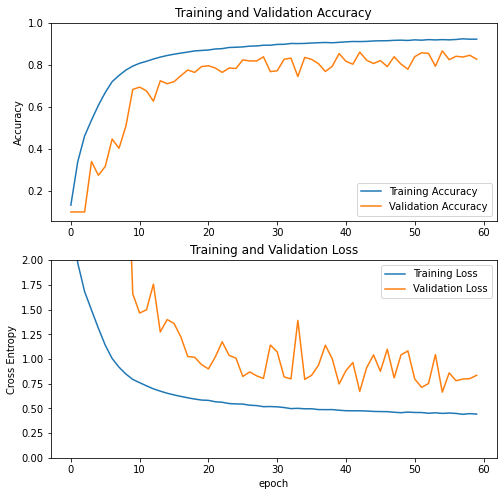

313/313 [==============================] - 4s 12ms/step - loss: 0.8351 - accuracy: 0.8273
Test loss:      0.8351244330406189
Test accuracy:  0.8273000121116638


In [0]:
# import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger, LearningRateScheduler
from datetime import datetime
model_name      = 'mobilenet__' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# build model
# compile model and create model
model = create_model(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS, 
                     MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, 
                     DATA_NUM_CLASSES, TRAINING_LR_MAX)

model.summary()
keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

def lr_schedule(epoch):
    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))
    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)
        #max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))(math.pi/2.0))) + TRAINING_LR_FINAL
    # debug - learning rate display
    # print(epoch)
    # print(lr)
    return lr

# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# train
initial_epoch_num = 0
history = model.fit(x=dataset_train,
                epochs=60,
                verbose=1, 
                callbacks=callbacks, 
                validation_data=dataset_test,
                initial_epoch=initial_epoch_num)

plot_training_curves(history)

# test
test_loss, test_accuracy = model.evaluate(x=dataset_test)
print('Test loss:     ', test_loss)
print('Test accuracy: ', test_accuracy)